In [167]:
from aocd import get_data, submit
import numpy as np
import sys
import itertools
from collections import defaultdict, Counter
import re

day = 16
year = 2022

data = get_data(day=day, year=year)



In [168]:
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

In [169]:
# data = """Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
# Valve BB has flow rate=13; tunnels lead to valves CC, AA
# Valve CC has flow rate=2; tunnels lead to valves DD, BB
# Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
# Valve EE has flow rate=3; tunnels lead to valves FF, DD
# Valve FF has flow rate=0; tunnels lead to valves EE, GG
# Valve GG has flow rate=0; tunnels lead to valves FF, HH
# Valve HH has flow rate=22; tunnel leads to valve GG
# Valve II has flow rate=0; tunnels lead to valves AA, JJ
# Valve JJ has flow rate=21; tunnel leads to valve II"""

In [170]:
pipes = [re.match(r"Valve (..)[^=]+=(\d+);[a-z ]+([A-Z, ]+)", l).groups() for l in data.split('\n')]

G = nx.Graph()
G.add_edges_from([(s,d) for s,_,dests in pipes for d in dests.split(', ')])
flows = { n:int(w) for n,w,_ in pipes }

assert len(pipes) == len(data.split('\n'))
# G

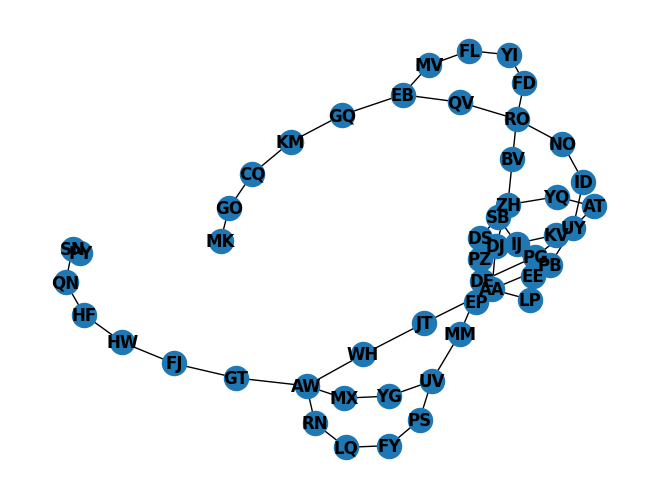

In [171]:
nx.draw(G, with_labels=True, font_weight='bold')

In [172]:
# min_flows = dict()
# # nx.bfs_tree(G, 'AA', depth_limit=30)
#     # print(t)
# cur_states = {('AA', (), 0)}
# tot_minutes = 30

# for minute in range(1, tot_minutes+1):
#     next_states = set()
#     for cur_node, open_valves, flow in cur_states:
#         flow_rate = sum(flows[n] for n in open_valves)
#         min_flow = flow + flow_rate * (tot_minutes-minute)
#         # print(f"Exploring: {cur_node} {open_valves} {flow}")
#         if min_flows.get(cur_node, -1) >= min_flow:
#             # print(f" -> Pruning: {flow} + {tot_minutes-minute} * {flow_rate} -> {min_flow} <= {min_flows[cur_node]}")
#             continue
#         # print(f" Adding min_flow: {cur_node} -> {min_flow}")
#         min_flows[cur_node] = min_flow
#         flow += flow_rate
#         if (cur_node not in open_valves) and flows[cur_node]:
#             next_states.add((cur_node, tuple(set([*open_valves, cur_node])), flow))
#         for next_node in G.neighbors(cur_node):
#             next_states.add((next_node, open_valves, flow))
#     if len(next_states) == 0:
#         pprint(cur_states)
#         pprint(min_flows)
#     print(f"Minute {minute}: max flow = {max(f for _,_,f in next_states)} ({len(next_states)} active states)")
#     cur_states = next_states
    
#     # pprint(min_flows)

In [173]:
# sum(v for k,v in flows.items() if k in ('BB', 'DD', 'HH'))

    # ('BB', 'HH') ('DD', 'JJ
flows

{'DJ': 0,
 'LP': 0,
 'GT': 0,
 'RO': 5,
 'PS': 0,
 'QV': 0,
 'MV': 0,
 'RN': 0,
 'HF': 0,
 'PY': 19,
 'AT': 0,
 'UY': 3,
 'YI': 0,
 'EB': 8,
 'ID': 0,
 'FY': 15,
 'GQ': 0,
 'HW': 0,
 'CQ': 17,
 'AW': 20,
 'BV': 0,
 'PB': 0,
 'MX': 0,
 'DE': 4,
 'AA': 0,
 'QN': 23,
 'GO': 0,
 'PZ': 0,
 'PG': 0,
 'FL': 18,
 'DS': 0,
 'ZH': 11,
 'KV': 0,
 'UV': 9,
 'WH': 0,
 'FD': 0,
 'FJ': 24,
 'JT': 0,
 'SN': 0,
 'KM': 0,
 'LQ': 0,
 'NO': 0,
 'SB': 0,
 'MK': 25,
 'YG': 0,
 'IJ': 16,
 'EP': 0,
 'MM': 0,
 'YQ': 0,
 'EE': 0}

In [174]:
all_valves = {k for k,v in flows.items() if v}
min_flows = dict()
# nx.bfs_tree(G, 'AA', depth_limit=30)
    # print(t)
cur_states = {(('AA', 'AA'), (), 0)}
tot_minutes = 26

for minute in range(1, tot_minutes+1):
    print(f"\nMinute {minute}: max flow = {max(f for _,_,f in cur_states)} ({len(cur_states)} active states)\n")

    # if minute == 7:
    # if (('BB', 'HH'), ('BB', 'DD', 'HH', 'JJ')) in {(x,y) for x,y,z in cur_states}:
    #     print("\n\n\nDEBUG:\n")
    #     print("minute", minute)
    #     pprint({c for c in cur_states if c[0] == ('BB', 'HH')})
    #     pprint(cur_states)
    #     raise Exception("")
        
    next_states = set()
    for cur_nodes, open_valves, flow in sorted(cur_states, key=lambda x: x[2], reverse=True):
        flow_rate = sum(flows[n] for n in open_valves)
        flow += flow_rate
        
        min_flow = flow + flow_rate * (tot_minutes-minute)
        # print(f"Exploring: {cur_nodes} {open_valves} {flow}")

        # check_for = (('CC', 'EE'), ('BB', 'CC', 'DD', 'EE', 'HH', 'JJ'))
        # if check_for == (cur_nodes, open_valves):
        #     print("\n\n\nDEBUG:\n")
        #     print("minute", minute, " | remains: ", tot_minutes-minute)
        #     print(cur_nodes, open_valves, flow)
        #     print("\n", min_flow, "<>", min_flows.get(cur_nodes, -1))
        #     print ({(c, c[2]+sum(flows[n] for n in c[1])) for c in cur_states if c[:2] == check_for})
        #     raise Exception("")
        
        if min_flows.get(cur_nodes, -1) >= min_flow:
            # print(f" -> Pruning: {flow} + {tot_minutes-minute} * {flow_rate} -> {min_flow} <= {min_flows[cur_nodes]}")
            continue
        
        # print(f" Adding min_flow: {cur_nodes} -> {min_flow}")
        min_flows[cur_nodes] = min_flow
        
        # assert min_flows.get((('BB', 'HH')), 0) < 184 + 76*15, (minute, cur_nodes)
        
        if set(open_valves) == set(all_valves):
            continue
        
        # if flow+flow_rate == 93:
        #     print("DEBUG:", cur_nodes, open_valves, flow)
        # flow += flow_rate
            
        next_states_n = [[], []]
        for i,cur_node in enumerate(cur_nodes):
            show_debug = (cur_node in open_valves)
            next_states_n[i] += ((cur_node, [cur_node] if flows[cur_node] else []),)
            for next_node in G.neighbors(cur_node):
                next_states_n[i] += ((next_node, []),)
        debug = {(tuple(sorted([cur_node1, cur_node2])), 
                             tuple(sorted(set([*valve1, *valve2, *open_valves]))), 
                             flow)
                            for cur_node1, valve1 in next_states_n[0]
                            for cur_node2, valve2 in next_states_n[1]
                            }

        next_states.update(debug)
        
    cur_states = next_states

    if len(cur_states) == 0:
        print(f"No more moves. Max flow: {max(min_flows.values())}")
        break
    
    # pprint(min_flows)
    # print(max(min_flows.values()), '\n')
    # 2532
    
    # ('BB', 'HH') ('DD', 'JJ


Minute 1: max flow = 0 (1 active states)


Minute 2: max flow = 0 (21 active states)


Minute 3: max flow = 0 (66 active states)


Minute 4: max flow = 0 (338 active states)


Minute 5: max flow = 15 (1147 active states)


Minute 6: max flow = 42 (2164 active states)


Minute 7: max flow = 73 (3358 active states)


Minute 8: max flow = 120 (4730 active states)


Minute 9: max flow = 191 (5123 active states)


Minute 10: max flow = 262 (6220 active states)


Minute 11: max flow = 337 (7100 active states)


Minute 12: max flow = 412 (7134 active states)


Minute 13: max flow = 510 (8887 active states)


Minute 14: max flow = 617 (8923 active states)


Minute 15: max flow = 724 (8959 active states)


Minute 16: max flow = 850 (7708 active states)


Minute 17: max flow = 991 (6428 active states)


Minute 18: max flow = 1132 (6549 active states)


Minute 19: max flow = 1273 (6573 active states)


Minute 20: max flow = 1414 (6232 active states)


Minute 21: max flow = 1555 (6004 active stat

In [175]:
max(min_flows.values())

2532

In [178]:
print(f"\nMinute {minute}: max flow = {max(f+sum(flows[n] for n in o) for _,o,f in cur_states)} ({len(cur_states)} active states)\n")


Minute 26: max flow = 2715 (3679 active states)



FOUND 12543202766584


12543202766584